# ClearMap2 parameter sweep on annotated volumes

The goal of this notebook is to perform a parameter sweep on a folder of tiff files that users have annotated and saved those annotations as RoiSet.zip files.

## Set up directories and imports

In [1]:
# imports 
import os,sys,json,glob,shutil
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import pandas as pd
import seaborn as sns
from scipy.spatial import distance


In [2]:
path_to_cm2 = '/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe/ClearMap2'
src = '/home/emilyjanedennis/Desktop/'
ann_folder = os.path.join(src,'mesospim_anns')
sys.path.append(path_to_cm2)

In [7]:
path_to_cm2 = '/Users/emilydennis/Desktop/GitHub/rat_BrainPipe/ClearMap2'
src = '/Users/emilydennis/Desktop/'
ann_folder = os.path.join(src,'mesospim_anns')
sys.path.append(path_to_cm2)

## Define functions

In [3]:
def convert_tiff_to_npy(src,ann_folder,this_ann_folder):
    file_loc = os.path.join(src,ann_folder,this_ann_folder)
    imported_tiff = tif.imread(file_loc)
    np.save(file_loc[0:-4] + '.npy',imported_tiff)

In [4]:
def get_ann_vals_in_np(src, ann_folder,ann_file):
    ann_vals=[]
    these_anns = os.listdir(os.path.join(src,ann_folder,ann_file))
    for j in np.arange(0,len(these_anns)):
        z = int(these_anns[j][0:4])
        y = int(these_anns[j][5:9])
        x = int(these_anns[j][10:14])
        ann_vals.append([z,y,x])
    return ann_vals

In [5]:
def pairwise_distance_metrics_given_cdists(
        ground_truth, predicted, y, cutoff=10, verbose=True):
    """
    Function to calculate the pairwise distances
    between two lists of zyx points.

    Inputs:
    -------
    ground_truth, predicted: each iterable
    consisting of ndimensional coordinates.
    y: matrix of distances between all
    elements of ground truth and predicted

    Returns:
    -------
    paired: list of [ground_truth"s index
    (from input list), predicted"s index (from input list), distance]
    tp,fp,fn: statistics on true positives,
    false positives, and false negatives.
    """
    # only keep those distances that are below the cutoff!
    truth_indices, pred_indices = np.where(y <= cutoff)
    dists = zip(y[truth_indices, pred_indices], truth_indices, pred_indices)

    # sort by smallest dist
    dists = sorted(dists, key=lambda x: x[0])

    used_truth = set()
    used_pred = set()
    paired = []
    for (i, dist) in enumerate(dists):
        d = dist[0]
        if d > cutoff:
            # we have reached distances beyond the cutoff
            break
        truth_idx = dist[1]
        pred_idx = dist[2]
        if truth_idx not in used_truth and pred_idx not in used_pred:
            paired.append((truth_idx, pred_idx, d))
            used_truth.add(truth_idx)
            used_pred.add(pred_idx)
        if len(used_truth) == len(ground_truth) or len(used_pred) == len(predicted):
            # we have used up all the entries from the shorter list
            break

    tp = len(paired)
    fn = len(ground_truth) - len(paired)
    fp = len(predicted) - len(paired)
    if verbose:
        print("TP: {}, FP: {}, FN: {}".format(tp, fp, fn))
    # print(paired)

    if verbose:
       plt.hist([xx[2] for xx in paired], bins=np.max((int(len(paired)/500), 10)))
       plt.title("Histogram of distances - pixel or microns")

    return paired, tp, fp, fn

In [6]:
def filter_cells(source, thresholds):
  """Filter a array of detected cells according to the thresholds.
  
  Arguments
  ---------
  source : str, array or Source
    The source for the cell data.
  sink : str, array or Source
    The sink for the results.
  thresholds : dict
    Dictionary of the form {name : threshold} where name refers to the 
    column in the cell data and threshold can be None, a float 
    indicating a minimal threshold or a tuple (min,max) where min,max can be
    None or a minimal and maximal threshold value.
  
  Returns
  -------
  sink : str, array or Source
    The thresholded cell data.
  """
  
  ids = np.ones(source.shape[0], dtype=bool);
  for k,t in thresholds.items():
    if t:
      if not isinstance(t, (tuple, list)):
        t = (t, None);
      if t[0] is not None:
        ids = np.logical_and(ids, t[0] <= source[k])
      if t[1] is not None:
        ids = np.logical_and(ids, t[1] > source[k]);
  cells_filtered = source[ids];
  return cells_filtered


In [7]:
def pairwise_distance_metrics(ground_truth, predicted, cutoff=10, verbose=True):
    """
    Function to calculate the pairwise distances
    between two lists of zyx points.

    Inputs:
    -------
    ground_truth, predicted: each iterable consisting of
    ndimensional coordinates.

    Returns:
    -------
    paired: list of [ground_truth"s index (from input list),
    predicted"s index (from input list), distance]
    tp,fp,fn: statistics on true positives, false positives,
    and false negatives.
    """

    if verbose:
        print("\nCalculating pairwise distances...")
    y = distance.cdist(ground_truth, predicted, metric="euclidean")
    return pairwise_distance_metrics_given_cdists(
       ground_truth, predicted, y, cutoff, verbose)

## Prepare data for cm2

In [8]:
listoftiffs = [f for f in os.listdir(ann_folder) if f.find('.tif') != -1]
listofanns = [f for f in os.listdir(ann_folder) if f.find('.RoiSet') != -1]

In [9]:
# import annotation volumes and reformat for CM2 if in tiff form

In [10]:
for i in np.arange(0,len(listoftiffs)):
    convert_tiff_to_npy(src,ann_folder,listoftiffs[i])

/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/tifffile/tifffile.py:3199: UserWarning: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
  warnings.warn(str(e))


In [11]:
listofnpys = [f for f in os.listdir(ann_folder) if f.find('.npy') != -1]

## Set up ClearMap2: imports and directories

In [12]:
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ImageProcessing.Experts.Cells as cells
from itertools import product

/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/line/line.py:395: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('color', np.float32, 4)])
/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/line/arrow.py:57: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('linewidth', np.float32, 1)
/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/isocurve.py:22: UserWarning: VisPy is not yet compatible with matplotlib 2.2+
  warnings.warn("VisPy is not yet compatible with matplotlib 2.2+")


In [13]:
directory = ann_folder
ws = wsp.Workspace('CellMap', directory=directory);

## Define CM2 parameters to sweep over

In [188]:
# Here we list the parameter ranges to sweep over.
background_sizes = [5,7] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [100,110]

In [189]:
# set up basic, shared cell_detection_parameters
cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']

processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )

## CM2 Parameter sweep

In [190]:
for file in listofnpys:
    if file.find('bck') == -1:
        ws.update(stitched=file)
        ws.info()

        for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
            this_cell_parameter_dict = cell_detection_parameter.copy()
            this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size)
            this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
            postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
            # actually detect cells:
            cells.detect_cells(ws.filename('stitched'),
                               ws.filename('stitched', postfix=postfix),
                               cell_detection_parameter=this_cell_parameter_dict,
                               processing_parameter=processing_parameter)

Workspace[CellMap]{/home/emilyjanedennis/Desktop/mesospim_anns}
              raw: no file
 autofluorescence: no file
         stitched: j319_642_2000-2400_1100-1500_1985-2010_stitched.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh110.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh120.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh130.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh140.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh150.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh160.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh180.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_raw_bck3_shpthresh190.npy
                   j319_642_2000-2400_1100-1500_1985-2010_stitched_

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.990
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.989
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.959
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.021
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.994
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.974
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.134
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.988
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.978
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.019
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.958
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.984
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.953
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.099
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.987
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.994
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.956
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.103
Workspace[CellMap]{/home/emilyjanedennis/Desktop/mesospim_anns}
              raw: no file
 autofluorescence: no file
         stitched: a253_5460_5170_19800-20280.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh110.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh120.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh130.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh140.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh160.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh180.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh190.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthresh210.npy
                   a253_5460_5170_19800-20280_raw_bck3_shpthre

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.963
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.951
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:08.991
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.946
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.951
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.029
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.948
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.044
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.945
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.941
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.947
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:08.953
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.012
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: elapsed time: 0:00:00.000
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.981
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.028
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.980
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.961
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.028
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.952
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.077
Workspace[CellMap]{/home/emilyjanedennis/Desktop/mesospim_anns}
              raw: no file
 autofluorescence: no file
         stitched: e143_6200-6600_3800-4200_2185-2210_stitched.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh110.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh120.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh130.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh140.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh160.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh180.npy
                   e143_6200-6600_3800-4200_2185-2210_stitched_raw_bck3_shpthresh190.np

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:01.005
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.021
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.948
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.072
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.012
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.939
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.030
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: elapsed time: 0:00:00.000
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.976
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.108
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.023
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.958
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.959
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.975
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.949
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.012
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.960
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.028
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.978
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.127
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.962
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.960
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.021
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.964
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.012
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:01.000
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.955
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.016
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: elapsed time: 0:00:00.000
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.949
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.967
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.966
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.066
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.020
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.952
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.012
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.976
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.962
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.115
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.024
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.965
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.025
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.986
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.020
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.972
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:01.029
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.957
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.953
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.949
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:09.119


## Calculate fp, fn, precision for each volume, save as data frame

In [192]:
list_of_vals = []
for i in np.arange(0,len(listoftiffs)):
    base_filename = listoftiffs[i][0:-4]
    if base_filename.find('642') != -1:
        print(base_filename)
        ann_vals = get_ann_vals_in_np(src,ann_folder,base_filename+'.RoiSet')
        sweep_list = [f for f in os.listdir(ann_folder) if np.all(f.find('shpthresh') != -1 and f.find(base_filename) != -1)]
        for j in np.arange(0,len(sweep_list)):
            for k in [2,4,6,8,10]:
                sweep_cells = pd.DataFrame(np.load(os.path.join(ann_folder,sweep_list[j])))
                sweep_cells = sweep_cells[sweep_cells['size']>k]
                paired, tp, fp, fn = pairwise_distance_metrics(ann_vals,sweep_cells[['x','y','z']],cutoff=30,verbose=False)
                if tp+fp > 0:
                    precision = tp/(tp+fp)
                    recall = tp/(tp+fn)
                    f1 = 2*((precision*recall)/(precision+recall))
                else:
                    precision = 0
                    recall = 0
                    f1=0
                list_of_vals.append([base_filename,sweep_list[j][-19:-17],sweep_list[j][-7:-4],k,tp,fp,fn,precision,recall,f1])
pd_to_save = pd.DataFrame(list_of_vals,columns=['all','bck','shpthresh','min_size','tp','fp','fn','precision','recall','f1'])
save_name = os.path.join(ann_folder,'ALL_642_sweep_RESULTS.csv')
pd_to_save.to_csv(save_name)
pd_642_orig=pd_to_save

j319_642_2000-2400_1100-1500_1985-2010_stitched
j319_642_2300-2700_3500-3900_1990-2015_stitched
j319_642_4000-4400_4100-4500_1790-1815_stitched
j319_642_1000-1400_4600-5000_1790-1815_stitched


,all,bck,shpthresh,min_size,tp,fp,fn,precision,recall,f1
25,a253_3990_2590_19800-20280,k5,180,2,2,1,53,0.666667,0.036364,0.068966
26,a253_3990_2590_19800-20280,k5,180,4,1,0,54,1.000000,0.018182,0.035714
27,a253_3990_2590_19800-20280,k5,180,6,1,0,54,1.000000,0.018182,0.035714
28,a253_3990_2590_19800-20280,k5,180,8,0,0,55,0.000000,0.000000,0.000000
29,a253_3990_2590_19800-20280,k5,180,10,0,0,55,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
440,a253_3990_2590_19800-20280,k5,450,2,0,0,55,0.000000,0.000000,0.000000
441,a253_3990_2590_19800-20280,k5,450,4,0,0,55,0.000000,0.000000,0.000000
442,a253_3990_2590_19800-20280,k5,450,6,0,0,55,0.000000,0.000000,0.000000
443,a253_3990_2590_19800-20280,k5,450,8,0,0,55,0.000000,0.000000,0.000000


In [219]:
pd_488 = pd_488_orig.copy()

pd_488['shpthresh']=pd_488['shpthresh'].astype('int')
pd_488['min_size']=pd_488['min_size'].astype('int')
pd_488= pd_488[pd_488['bck']=='k7']
pd_488 = pd_488[pd_488['shpthresh']==110]
pd_488 = pd_488[pd_488['min_size']==6]

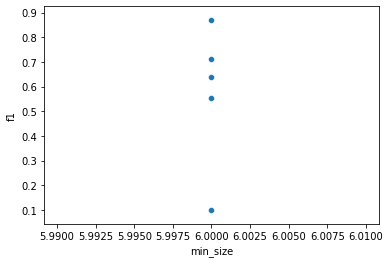

In [220]:
sns.scatterplot(data=pd_488,x='min_size',y='f1')
#plt.ylim([0.6,1])
#k5, 110,4 // 120-130,2
#k7, 110,6 // 120,4
#k9, 130,4 // 120,6 // 110,10
#11, 130,6 //120,10
#13, 130,8

In [244]:
pd_642 = pd_642_orig.copy()
pd_642['shpthresh']=pd_642['shpthresh'].astype('int')
pd_642['min_size']=pd_642['min_size'].astype('int')

pd_642 = pd_642[pd_642['shpthresh'] <150]
pd_642 = pd_642[pd_642['bck']!='k3']

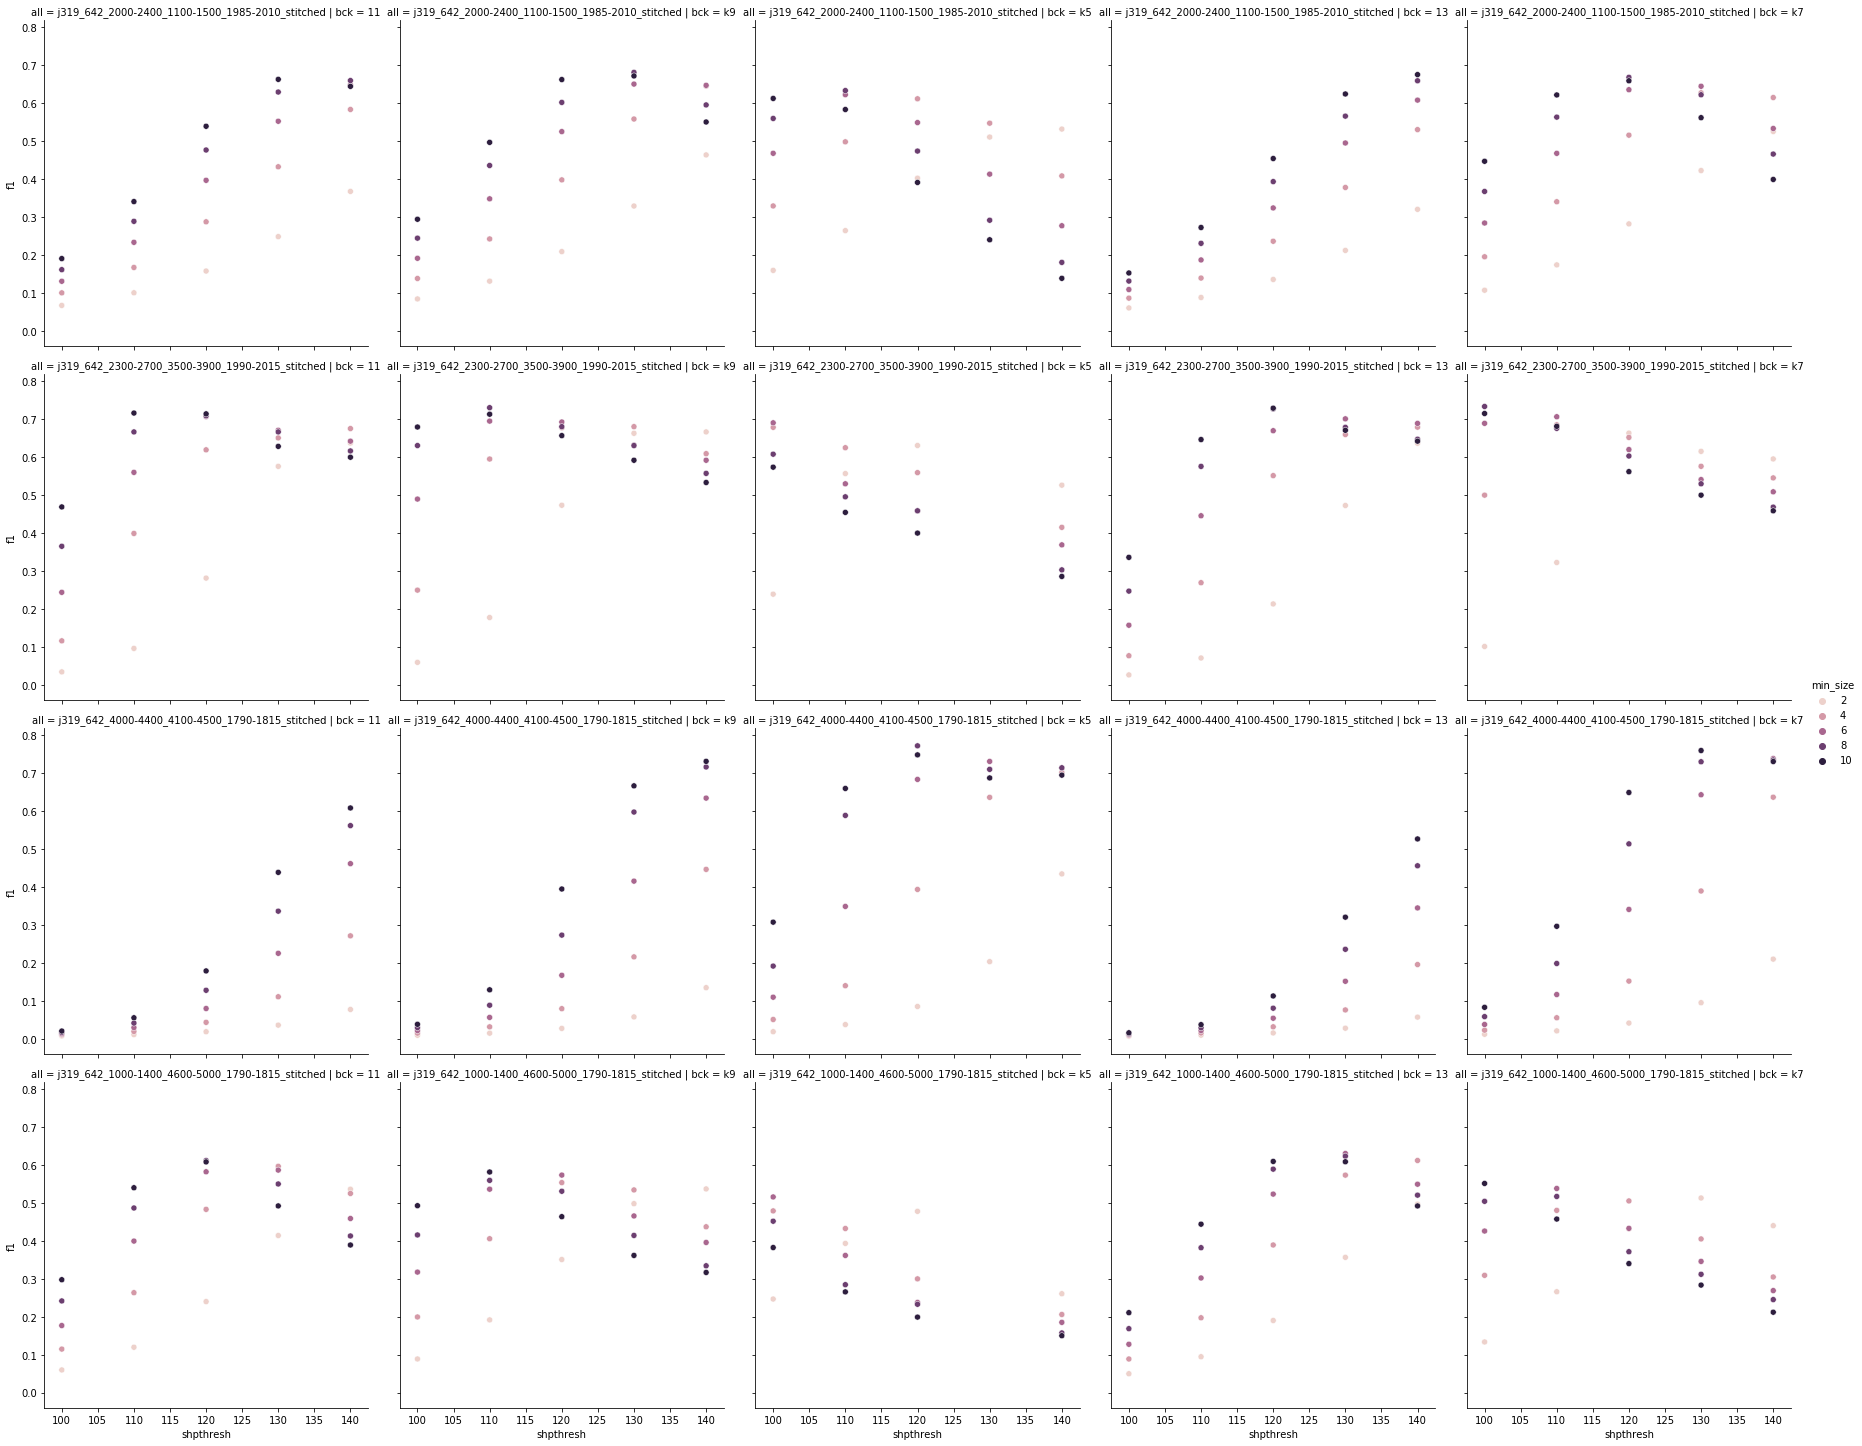

In [246]:
sns.relplot(data = pd_642,x='shpthresh',y='f1',col='bck',row='all',hue='min_size')


In [ ]:
#k5 120 
#k7                                                                                                                                                                                         
#k9 130-140 
# 11, 140
# 13, 130-140